In [ ]:
# Data Preparation (same as before)
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Load and preprocess the Ontario energy dataset
data = pd.read_csv(r'data\processed\yukon_energy.csv')
data['date'] = pd.to_datetime(data['date'])

# Ensure all generation types are consistent across dates
df_grouped = data.groupby(['date', 'generation_type'], as_index=False)['megawatt_hours'].sum()
unique_generation_types = df_grouped['generation_type'].unique()

def standardize_generation_types(df, unique_types):
    all_months = df['date'].unique()
    standardized_rows = [
        {'date': month, 'generation_type': g_type, 'megawatt_hours': 0}
        for month in all_months
        for g_type in unique_types
        if g_type not in df[df['date'] == month]['generation_type'].values
    ]
    return pd.concat([df, pd.DataFrame(standardized_rows)], ignore_index=True)

df_standardized = standardize_generation_types(df_grouped, unique_generation_types)
df_pivot = df_standardized.pivot(index='date', columns='generation_type', values='megawatt_hours').fillna(0)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_pivot)

# Create sliding windows
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 36  # Sliding window size (3 years)
X, y = create_sequences(data_scaled, n_steps)

# Split into training and testing sets
test_size = 24  # Reserve last 24 months (2 years) for testing
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# Print shapes to verify
print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set: X={X_test.shape}, y={y_test.shape}")


Training set: X=(119, 36, 5), y=(119, 5)
Testing set: X=(24, 36, 5), y=(24, 5)


In [58]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_transformer(input_shape, output_shape):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding
    position = tf.range(start=0, limit=input_shape[0], delta=1)  # n_steps
    embedding = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(position)  # features
    embedding = tf.expand_dims(embedding, axis=0)  # Add batch dimension
    embedding = tf.tile(embedding, [tf.shape(inputs)[0], 1, 1])  # Match batch size
    x = inputs + embedding

    # Transformer Encoder Blocks
    for _ in range(4):  # Reduced to 6 encoder layers for efficiency
        x1 = layers.MultiHeadAttention(num_heads=512, key_dim=input_shape[1])(x, x)  # num_heads = 8
        x2 = layers.LayerNormalization(epsilon=1e-6)(x + x1)  # Residual connection
        x3 = layers.Dense(input_shape[1], activation="relu")(x2)  # Match features dimension
        x = layers.LayerNormalization(epsilon=1e-6)(x2 + x3)  # Another residual connection

    # Output Layer
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(output_shape, activation='linear')(x)

    model = models.Model(inputs, outputs)
    return model


In [ ]:
# Define the model with corrected input shapes
input_shape = (X_train.shape[1], X_train.shape[2])  # (n_steps, features)
output_shape = y_train.shape[1]  # Number of target features

transformer_model = build_transformer(input_shape, output_shape)

# Compile the model
transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = transformer_model.fit(
    X_train, y_train,
    epochs=32,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=2
)

# Evaluate on test set
test_loss, test_mae = transformer_model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


Epoch 1/32
2/2 - 16s - loss: 0.3540 - mae: 0.4923 - val_loss: 0.3173 - val_mae: 0.4996 - 16s/epoch - 8s/step
Epoch 2/32
2/2 - 5s - loss: 0.1217 - mae: 0.3009 - val_loss: 0.2070 - val_mae: 0.3506 - 5s/epoch - 2s/step
Epoch 3/32
2/2 - 5s - loss: 0.0907 - mae: 0.2410 - val_loss: 0.1933 - val_mae: 0.3487 - 5s/epoch - 2s/step
Epoch 4/32
2/2 - 4s - loss: 0.0616 - mae: 0.1955 - val_loss: 0.1648 - val_mae: 0.3353 - 4s/epoch - 2s/step
Epoch 5/32
2/2 - 5s - loss: 0.0555 - mae: 0.1871 - val_loss: 0.1141 - val_mae: 0.2508 - 5s/epoch - 2s/step
Epoch 6/32
2/2 - 5s - loss: 0.0425 - mae: 0.1556 - val_loss: 0.1032 - val_mae: 0.2457 - 5s/epoch - 2s/step
Epoch 7/32
2/2 - 5s - loss: 0.0456 - mae: 0.1680 - val_loss: 0.1003 - val_mae: 0.2417 - 5s/epoch - 2s/step
Epoch 8/32
2/2 - 5s - loss: 0.0437 - mae: 0.1612 - val_loss: 0.0950 - val_mae: 0.2211 - 5s/epoch - 2s/step
Epoch 9/32
2/2 - 5s - loss: 0.0450 - mae: 0.1561 - val_loss: 0.0908 - val_mae: 0.2143 - 5s/epoch - 3s/step
Epoch 10/32


1/1 [==============================] - 5s 5s/step


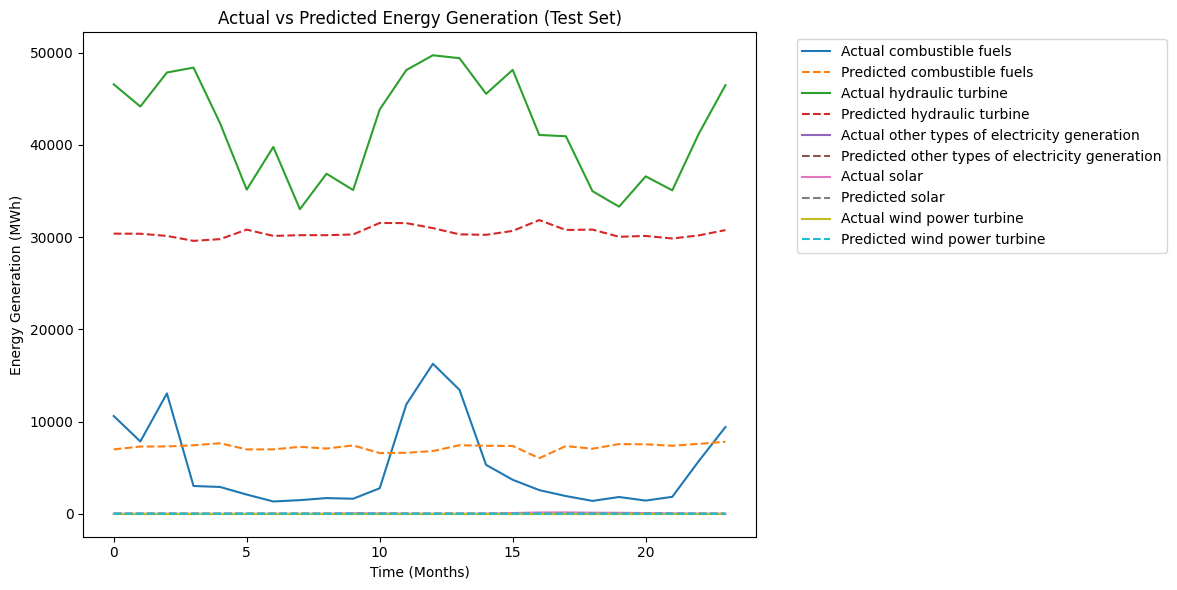

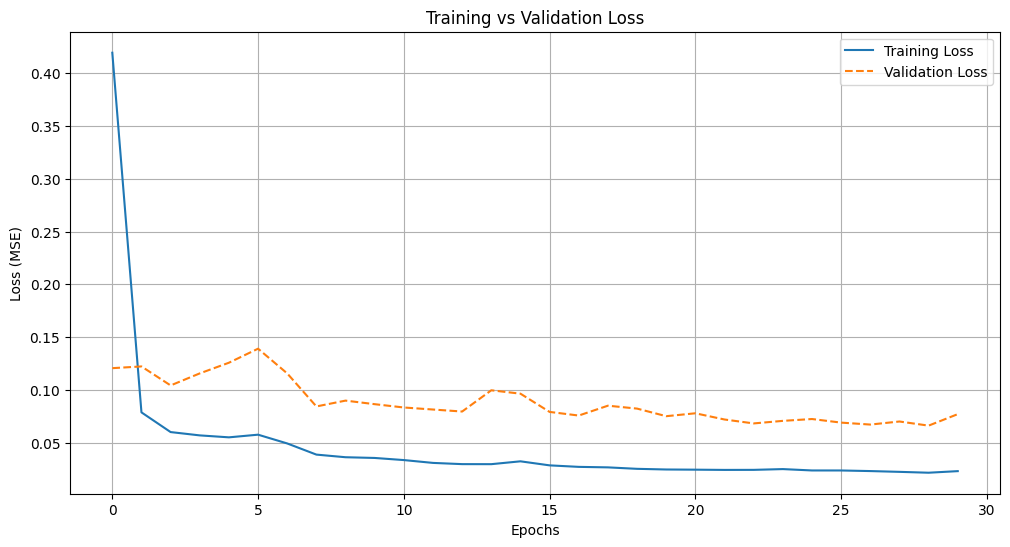

In [ ]:
# Predict on the test set
y_pred = transformer_model.predict(X_test)

# Rescale back to original scale
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Plot actual vs predicted for each generation type
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
time_range = range(len(y_test_rescaled))

for i, col in enumerate(df_pivot.columns):
    plt.plot(time_range, y_test_rescaled[:, i], label=f"Actual {col}", linestyle='solid')
    plt.plot(time_range, y_pred_rescaled[:, i], label=f"Predicted {col}", linestyle='dashed')

plt.title("Actual vs Predicted Energy Generation (Test Set)")
plt.xlabel("Time (Months)")
plt.ylabel("Energy Generation (MWh)")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid()
plt.show()

#GET RMSE AND R2 SCORE

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"RMSE: {rmse}, R2 Score: {r2}")


Epoch 1/5
5/5 - 13s - loss: 0.0309 - mae: 0.1186 - 13s/epoch - 3s/step
Epoch 2/5
5/5 - 14s - loss: 0.0300 - mae: 0.1126 - 14s/epoch - 3s/step
Epoch 3/5
5/5 - 14s - loss: 0.0295 - mae: 0.1114 - 14s/epoch - 3s/step
Epoch 4/5
5/5 - 14s - loss: 0.0277 - mae: 0.1101 - 14s/epoch - 3s/step
Epoch 5/5
5/5 - 14s - loss: 0.0272 - mae: 0.1034 - 14s/epoch - 3s/step
1/1 [==============================] - 0s 118ms/step
generation_type  combustible fuels  hydraulic turbine  \
2022-12-01             4763.488569       35410.693829   
2023-01-01             5566.087092       35586.990816   
2023-02-01             5642.233627       35466.793457   
2023-03-01             6201.877903       35463.901578   
2023-04-01             6662.917256       35514.970855   

generation_type  other types of electricity generation      solar  \
2022-12-01                                   -0.037007  10.462936   
2023-01-01                                   -0.047898  13.094629   
2023-02-01                                

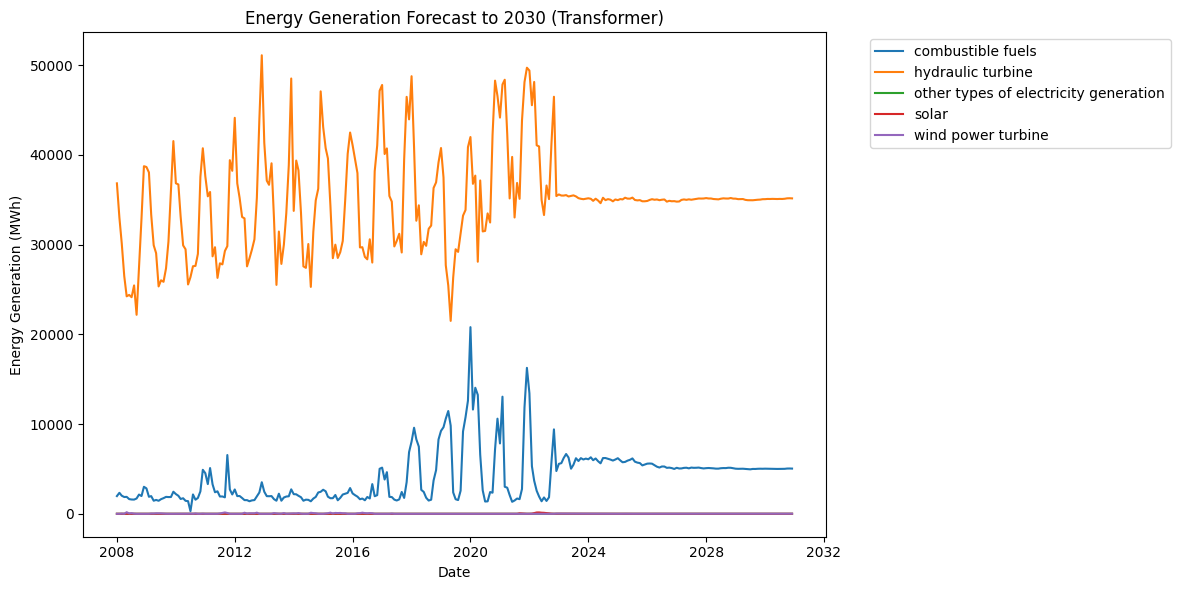

In [ ]:
# Retrain the model on the entire dataset
transformer_model.fit(
    X, y,
    epochs=5,  # Retrain for 50 epochs (can adjust as needed)
    batch_size=32,
    verbose=2
)

# Define the forecasting horizon (from the last date in the dataset to 2030-12-31)
forecast_horizon = pd.date_range(df_pivot.index[-1] + pd.DateOffset(months=1), '2030-12-01', freq='MS')

# Start with the last n_steps of the dataset
forecast_input = data_scaled[-n_steps:].reshape(1, n_steps, X_train.shape[2])

# Placeholder for predictions
forecast = []

# Iteratively predict the future
for _ in range(len(forecast_horizon)):
    prediction = transformer_model.predict(forecast_input)
    forecast.append(prediction[0])
    forecast_input = np.append(forecast_input[:, 1:, :], prediction.reshape(1, 1, -1), axis=1)

# Rescale predictions back to original values
forecast_rescaled = scaler.inverse_transform(forecast)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast_rescaled, index=forecast_horizon, columns=df_pivot.columns)

# Display the forecast
print(forecast_df.head())

# Combine historical and forecasted data
combined = pd.concat([df_pivot, forecast_df])

# Plot
plt.figure(figsize=(12, 6))
for column in df_pivot.columns:
    plt.plot(combined.index, combined[column], label=column)

plt.title("Energy Generation Forecast to 2030 (Transformer)")
plt.xlabel("Date")
plt.ylabel("Energy Generation (MWh)")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()
